# Import

In [1]:
%matplotlib inline

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

/home/duyetdev/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def jitter(values, sd=0.25):
    return [np.random.normal(v, sd) for v in values]

In [3]:
def clean_text(df, col):
    """A function for keeping only alpha-numeric
    characters and replacing all white space with
    a single space.
    """
    return df[col].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [4]:
def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

In [5]:
def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*") for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

In [6]:
def normalize(tokenized_words):
    """Removes stop words, numbers, short words, and lowercases text.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    stop_words = stopwords.words('english')
    return [[w.lower() for w in sent
             if (w.lower() not in stop_words)]
            for sent in tokenized_words]

In [7]:
def features(df):
    df = df.copy()
    df['n_questionmarks'] = count_pattern(df, 'Text', '\?')
    df['n_periods'] = count_pattern(df, 'Text', '\.')
    df['n_apostrophes'] = count_pattern(df, 'Text', '\'')
    df['first_word'] = df.text_clean.apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is']
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
        df[col_wc] = count_pattern(df, 'text_clean', w)
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df['n_words'] = df.Text.apply(lambda x: len(split_on_word(x)))
    return df

In [8]:
def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

# Data

In [12]:
training = pd.read_csv('data/newtrain.csv')
training.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,2,what is the best photo slideshow creation appl...


In [14]:
test = pd.read_csv('./data/newtest.csv')
test.head()

,Id,Text
0,1,ave u ever been dump before? ???
1,2,my wife is not interested in sex
2,3,best looking doctor on er?
3,4,does sbc yahoo 2wire installation software sup...
4,5,why and when was the mason-dixon line completed?


## Cleaning data

Remove non-alpha numeric characters and extra whitespace.

In [15]:
training['text_clean'] = clean_text(training, 'Text')
test['text_clean'] = clean_text(test, 'Text')

## Feature Engineering

### TF-IDF

In [16]:
all_text = training['text_clean'].values.tolist() + test['text_clean'].values.tolist()
vocab = flatten_words(all_text, get_unique=True)
tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
training_matrix = tfidf.fit_transform(training.text_clean)
test_matrix = tfidf.fit_transform(test.text_clean)

In [20]:
training_matrix

<2698x8820 sparse matrix of type '<type 'numpy.float64'>'
	with 17423 stored elements in Compressed Sparse Row format>

### Other Features

In [24]:
training = features(training)
training = pd.concat([training, pd.DataFrame(training_matrix.todense())], axis=1)
training.head(3)

,Category,Text,text_clean,n_questionmarks,n_periods,n_apostrophes,n_what,fw_what,n_how,fw_how,...,8810,8811,8812,8813,8814,8815,8816,8817,8818,8819
0,5,why are yawns contagious? when people yawn,why are yawns contagious when people yawn,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,what is trans fat? how to reduce that? i heard...,what is trans fat how to reduce that i heard t...,4,1,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,roth ira vs 401k? what is the difference betwe...,roth ira vs 401k what is the difference betwee...,3,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
test = features(test)
test = pd.concat([test, pd.DataFrame(test_matrix.todense())], axis=1)

## Split the Training Data

In [26]:
train, dev = cross_validation.train_test_split(training, test_size=0.2, random_state=1868)

# Training with SVM

In [27]:
svm = LinearSVC(dual=False, max_iter=5000)

In [28]:
features = train.columns[3:]
X = train[features].values
y = train['Category'].values
features_dev = dev[features].values


## Cross-validation

In [29]:
kf = cross_validation.KFold(n=len(train), n_folds=5)

In [30]:
print(np.array([svm.fit(X[tr], y[tr]).score(X[te], y[te]) for tr, te in kf]).mean())

0.519910629887


# Test

In [31]:
svm.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [32]:
dev_predicted = svm.predict(features_dev)

In [33]:
accuracy_score(dev.Category, dev_predicted)

0.53888888888888886

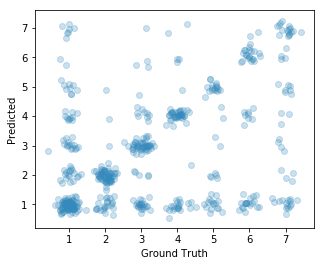

In [36]:
%matplotlib inline
plt.figure(figsize=(5, 4))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Predicted')